# Removing Artifacts in EEG Data

## Install MNE Library

In [1]:
# install MNE library
!pip install -q mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.4 MB/s eta 0:00:00


## Import EEG Data File

In [2]:
# import EEG data files
!wget -q https://datascience.faseela.ma/wp-content/uploads/data-science/N400_dataset_14-raw.fif

## Import Libraries

In [3]:
import mne
mne.set_log_level('error')

import matplotlib.pyplot as plt

## Read the Raw Data

In [4]:
# read EEG raw data
raw = mne.io.read_raw_fif('N400_dataset_14-raw.fif', preload='True')

# set the easycap-M1 montage to your raw data
raw.set_montage('easycap-M1', on_missing='ignore')


<Raw | N400_dataset_14-raw.fif, 16 x 623850 (1247.7 s), ~76.2 MiB, data loaded>

## Filter the Data for ICA

ICA captures features of the data that explain the most variance, which is any deviation from the mean.

Blinks and eye movements are well-captured by ICA because they are so much larger than EEG, and so they contain a lot of the variance in the EEG recordings.

Likewise, low-frequency drift in data explains large amounts of variance, because of the 1/f property of EEG data, the lowest frequencies contain the most power.<br>
Low-frequency drift in data refers to slow, gradual shifts in the baseline or average value of a time series, and may be caused by physiological noise.

For this reason, ICA works best on data that has more low-frequency power removed than the data that we ultimately want to analyze.

So we will filter the data for ICA with a **1 Hz** high-pass cutoff.

In [5]:
# Filter settings
ica_low_cut = 1.0
hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)

## Segment the Data for ICA

ICA works best with segments of data, rather than the continuous raw data.

We use the word **epoch** to refer to a segment of EEG data, which means "a period of time".

We will segment the entire raw data recording into a series of consecutive 1 s segments.

We use the MNE function **`make_fixed_length_events()`** to create an array of equally spaced events from a **`Raw`** instance.

We use the MNE class constructor **`mne.Epochs()`** to extract epochs from a **`Raw`** instance.

The **`Epochs`** object is a data structure for representing and analyzing equal-duration chunks of the EEG/MEG signal.

In [6]:
# set epoch duration to 1 s
tstep = 1.0

# create equally spaced events
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)

# create Epochs object
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

### Visualizing **`Epochs`** Object

We use the **`plot()`** method to visualize the **`Epochs`** object:

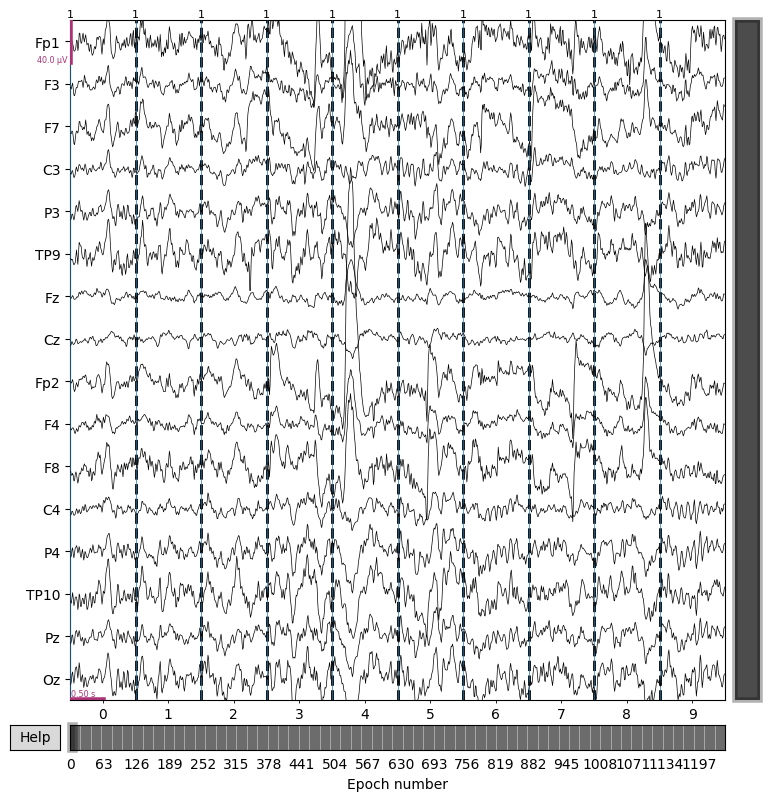

In [7]:
# visualize the Epochs object
epochs_ica.plot(n_epochs=10, events=True);

## Pre-Clean Data for ICA

We use the **Autoreject** library that allows an automated artifact rejection for MEG and EEG data.

The Autoreject algorithm is an automated and data-driven way of determining a threshold to distinguish between "noisy" and "clean" channels and epochs in the data.

### Install Autoreject

In [8]:
!pip install -q autoreject

### Import **`Autoreject`**

In [9]:
from autoreject import AutoReject

### Create an **`AutoReject`** object

The Autoreject algorithm identifies which sensors are "bad" in a given epoch and, if certain conditions are met, interpolates them using data from neighboring "good" sensors.

We use the **`AutoReject()`** class constructor to create an **`AutoReject`** object, which we call **`ar`**.

The **`AutoReject()`** class constructor accepts several parameters to control the artifact rejection process:
* **`n_interpolates`**: The number of sensors to interpolate.
* **`random_state`**: A seed for the random number generator for reproducible results. The value 42 is used by convention.
* **`picks`**: Channels to include.
* **`n_jobs`**: The number of parallel jobs to run.
* **`verbose`**: Controls the verbosity of the output.

We use the **`fit()`** method of the object on the **`epochs_ica`** data.<br>
This will compute the threshold for each channel and epoch, and store it in the **`ar`** object. We save the list of rejected epochs and channels to **`reject_log`**.

**Note:** **`AutoReject`** is a computationally-intensive algorithm, meaning it can take a long time to run, possibly several minutes.

In [ ]:
# create an Autoreject object
ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info,
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1,
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)

### Visualizing Epochs

To visualize the epochs that **`autoReject`** marked as good, bad, or interpolated, we use the **`plot()`** method of the **`RejectLog`** object, which is obtained after fitting **`AutoReject`** to the data.

The plot is shown in the figure below, where the y-axis is the channels, and the x-axis is epochs.

The plot produced by **`reject_log.plot()`** will be an image with different colors indicating the status of each data point:
* Green (or light color): Good data.
* Blue (or medium dark color): Bad segment, but not chosen for interpolation (epoch may be dropped entirely if it exceeds the consensus threshold).
* Red (or dark color): Bad segment that was interpolated.

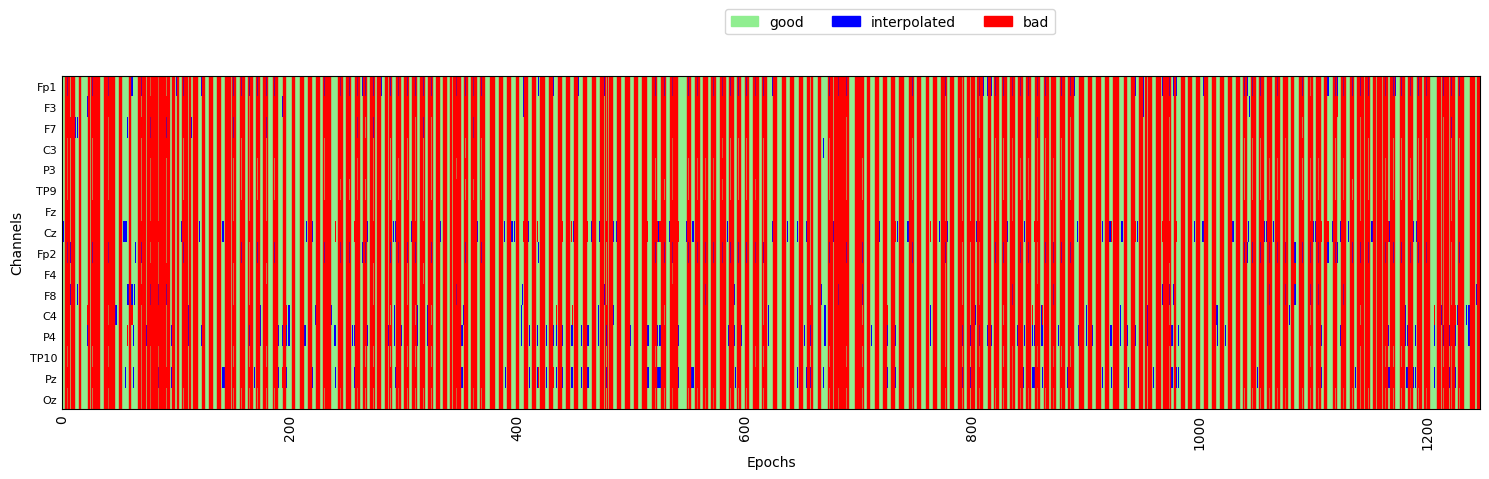

In [ ]:
# visualizing the results of the fit
fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

## Fit ICA to the Data

Now that we’ve marked bad epochs to exclude from ICA, we can run ICA itself.

Running ICA on our data involves two steps:

1. Create an **`ICA`** object with the parameters (passed as kwargs) that we want to use,
2. use the **`fit()`** method to fit this object to the data — which effectively runs the algorithm on the data, using the parameters set in step 1.

### Parameters

The **`n_components`** parameter specifies the number of independent components we want.<br>
We specify a floating point number ≤ 1, which represents the percentage of data that the ICA components should, collectively, explain.<br>
Here we use the number `.99`, which means we want as many independent components as needed to explain 99% of the variance in the data. Typically this is a good value to use.

The **`random_state`** parameter ensure that the same "random" parameters are used each time, meaning that our results will be replicable. The value 42 is used by convention.

In the **`ica.fit()`** method call, we pass the **`epochs_ica`** data but, critically, we include the selector **`[~reject_log]`** to exclude the epochs that were marked as bad by **`AutoReject`** (the Python operator **`~`** is the logical operator **`NOT`**).

The **`decim`** parameter is an integer that specifies to use only every Nth sample in the data when computing the ICs.<br>
Using a higher value speeds up computation but reduces the data used for the fit.

In [ ]:
# ICA parameters
random_state = 42
ica_n_components = .99

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,29 iterations on epochs (119739 samples)
ICA components,12
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


The **`.fit()`** method produces the output above, showing some of the resulting parameters stored in **`ica`**.

## Visualize ICA components

Every IC (an independent component identified by ICA) is a signal that varies over time, that has a "weighting" at each channel - reflecting how strongly present that IC is in that channel.

In other words, the time course of an IC is the same at all electrodes, but it is bigger at some, and smaller at others.

We can visualize each component as a scalp topography map, showing where on the scalp the IC is largest.

**Topo maps**, as they are often abbreviated, are a different way of visualizing EEG data than we’ve seen before.

Whereas previously we’ve viewed EEG as electrical potential over time, topo maps show how the potentials are distributed spatially, at a specific point in time (or averaged over a period of time).

The maps use the red-blue color map where red is positive, blue is negative, and white is zero.

The following figure illustrates topo maps along with EEG channel signals:

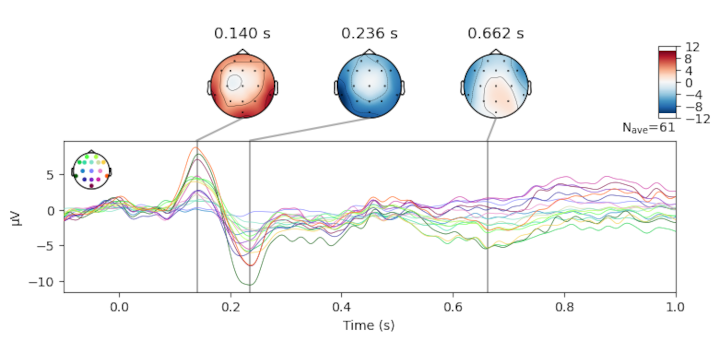

"Positive" and "negative" in ICA topo maps can reflect cases where a component has the same shape over time, but opposite (negative vs. positive) electrical polarity at different scalp locations.

This can be seen, for example, in ICA002 below, which reflects the opposite polarities induced by horizontal eye movements.

Indeed, in the figure below we can see that a few ICs are likely ocular artifacts, because they weight most heavily around the front of the head (the top of each subplot, where the nose is drawn). In particular, ICA001 is likely blink artifacts, and ICA002 is likely horizontal eye movements.

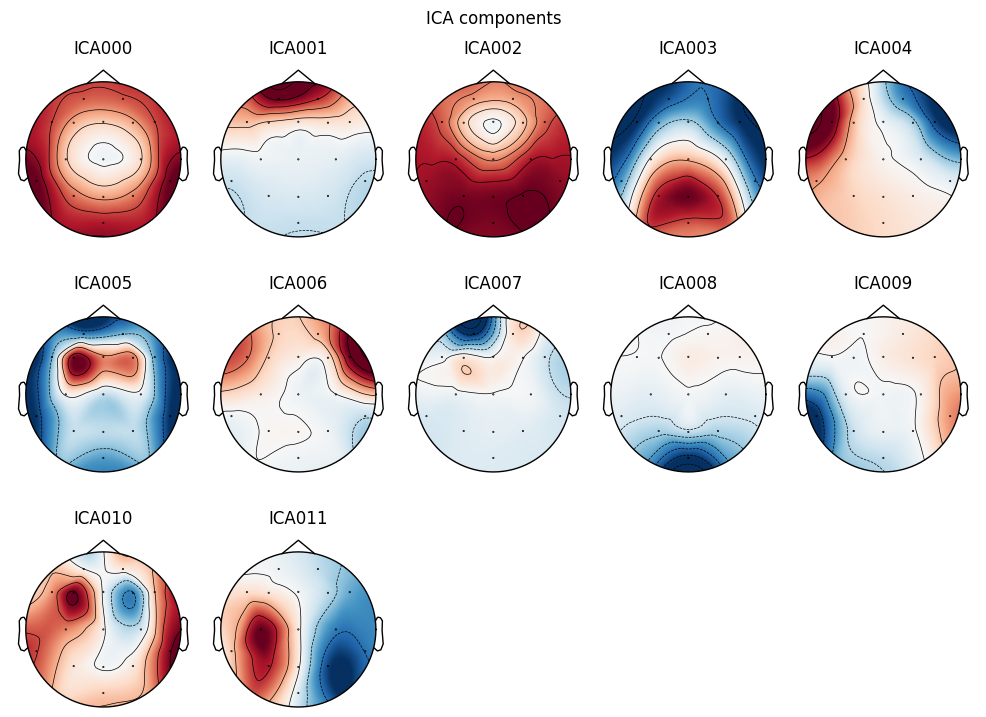

In [ ]:
# visualize ICA components
ica.plot_components();

## Visualize IC properties

We use the **`plot_properties()`** method to visualize the IC properties.

This provides a detailed diagnostic plot for a specific component, including its topography, power spectrum, a raster plot of how the IC weights on each trial, variance of the component across channels and time.

It is often used after identifying a potentially bad component from **`plot_components()`**.

A raster plot is a visual tool for showing data points (like neural spikes) over time or across trials, using dots or colors on a grid where each row is a trial/unit and the X-axis is time, excellent for spotting patterns in large datasets like brain activity.

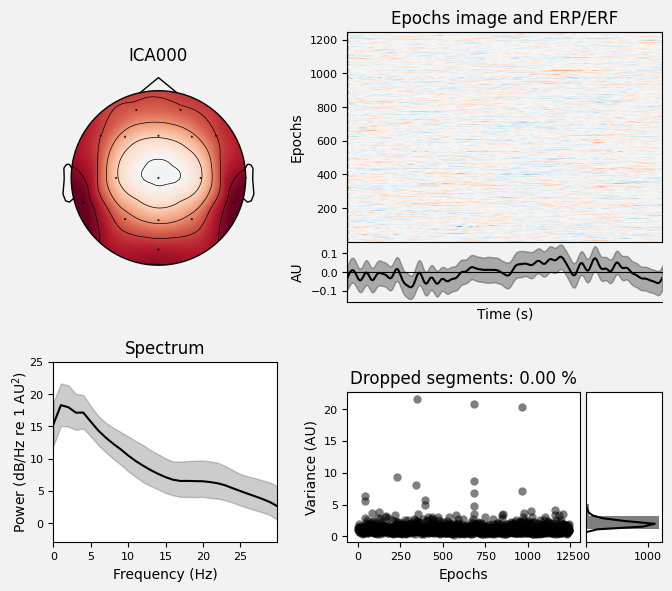

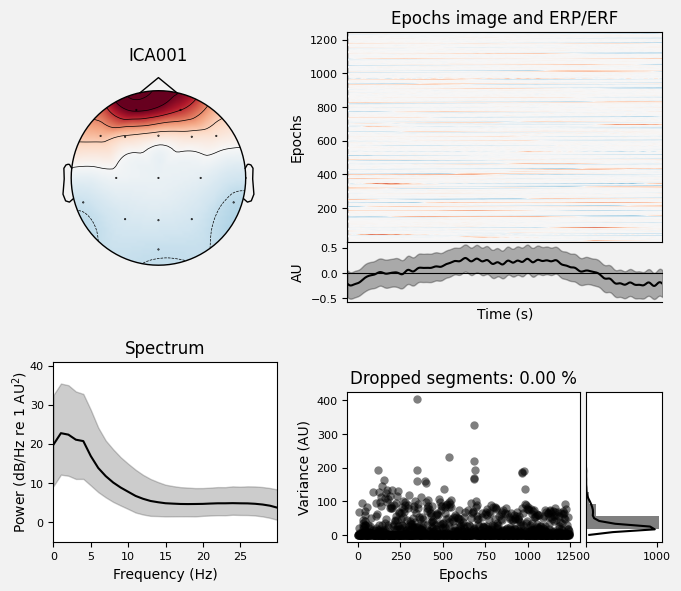

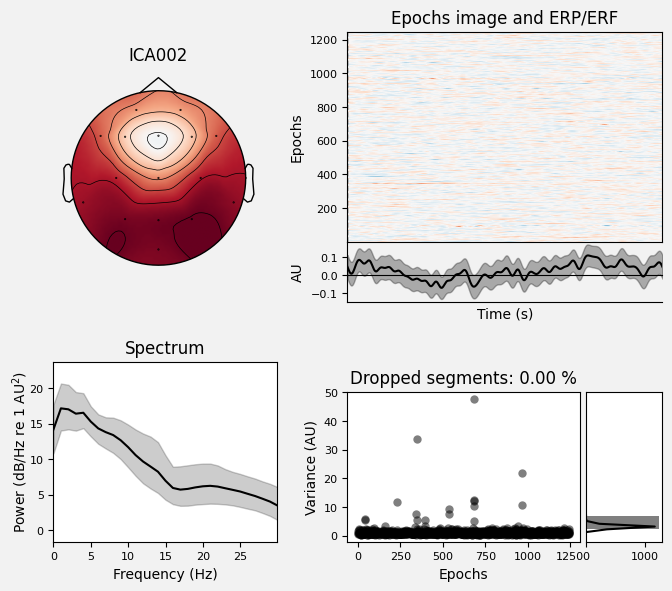

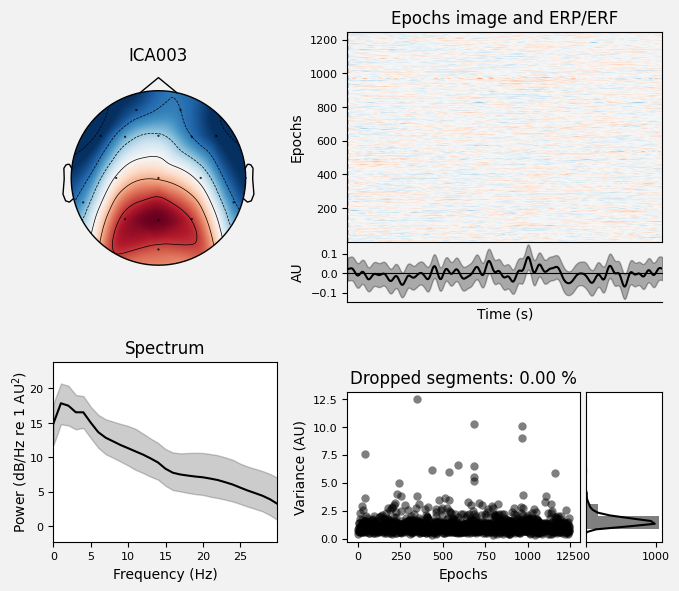

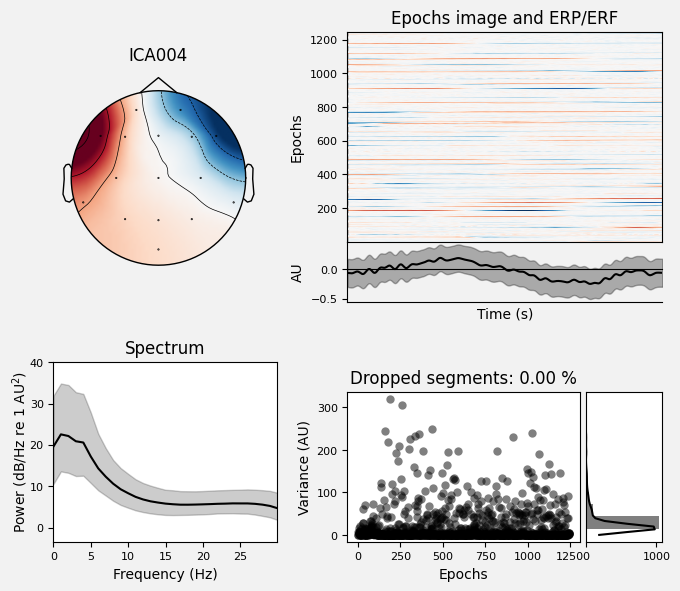

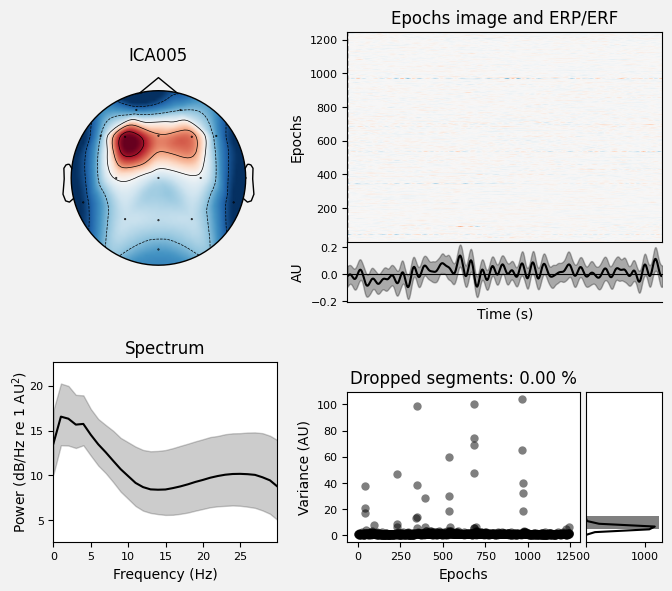

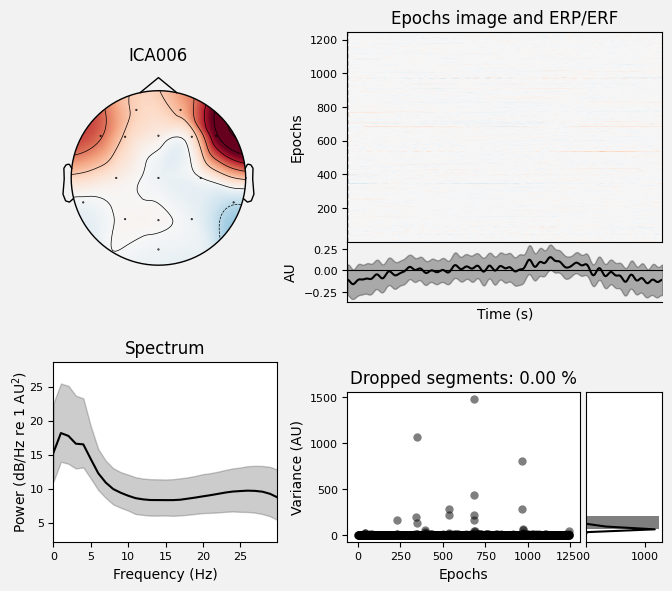

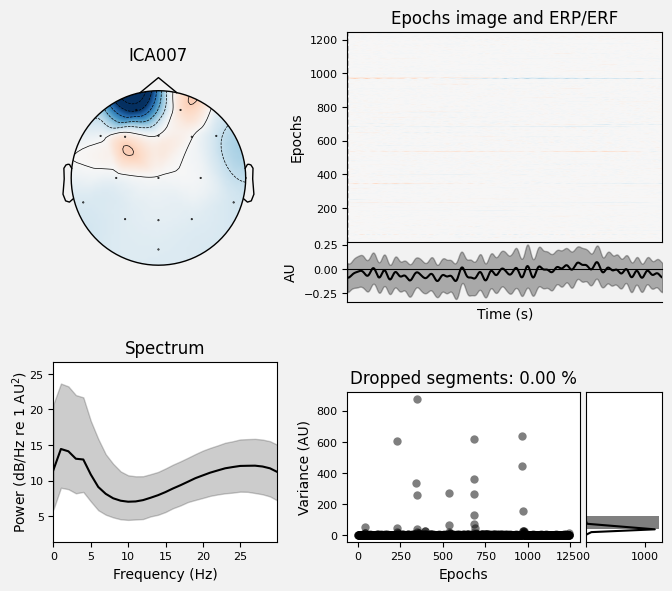

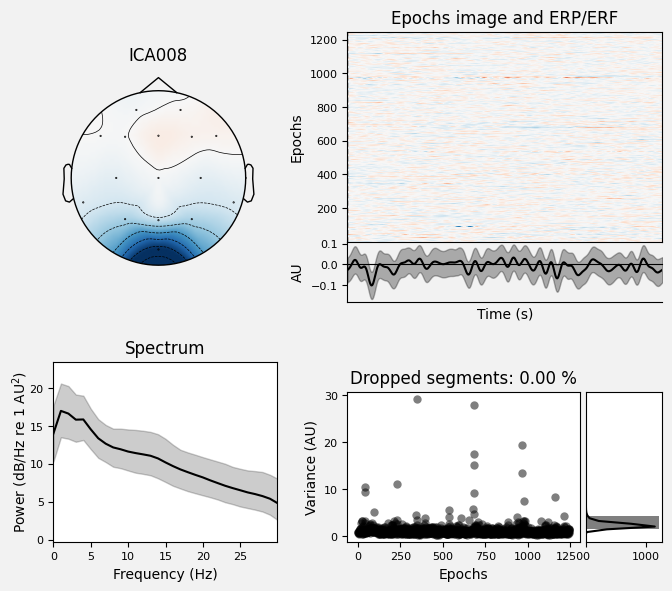

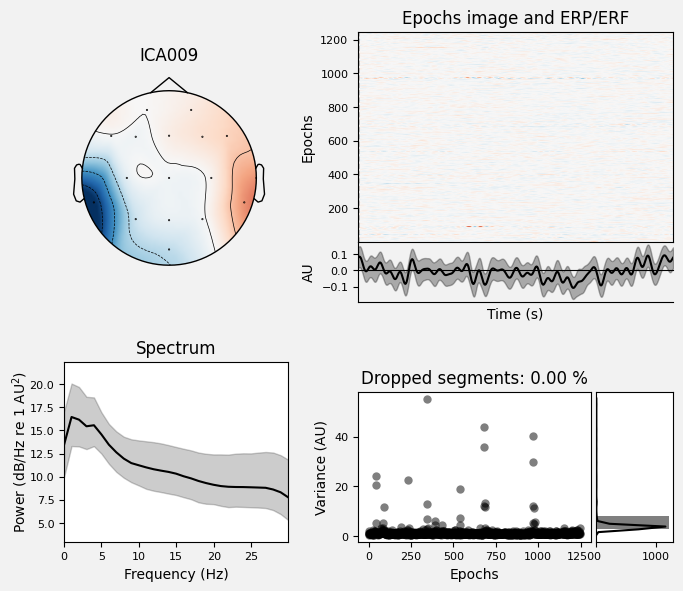

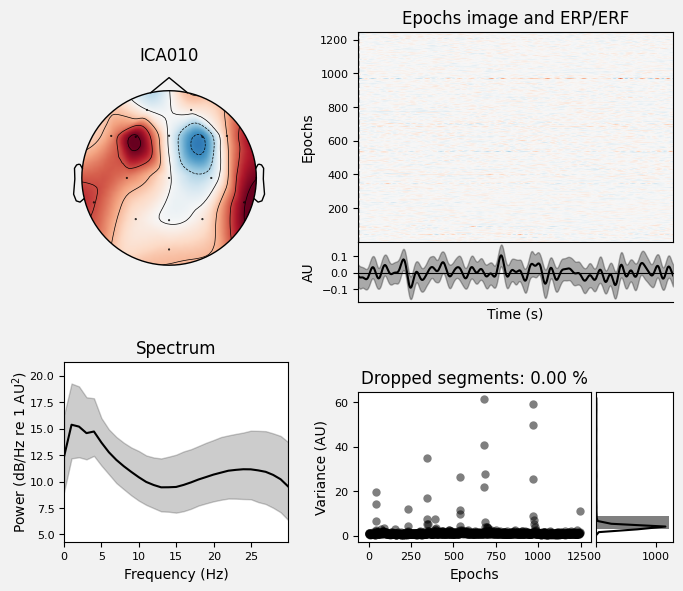

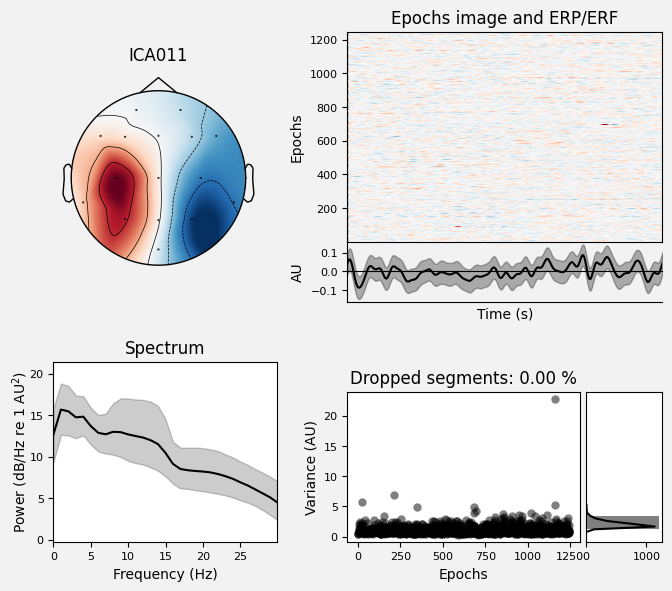

In [ ]:
# visualize ICA components properties
ica.plot_properties(epochs_ica,
                    picks=range(0, ica.n_components_),
                    psd_args={'fmax': hi_cut});

## Save ICA to a File

An **`ICA`** object has a **`save()`** method that will create a **`.fif`** file:

In [ ]:
# save ICA to a file
ica.save('N400_dataset_14-ica.fif', overwrite=True);